<img align="left" src="https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/tapi-logo-small.png" />

This notebook free for educational reuse under [Creative Commons CC BY License](https://creativecommons.org/licenses/by/4.0/).

Created by [Xanda Schofield](https://www.cs.hmc.edu/~xanda) for the 2022 Text Analysis Pedagogy Institute, with support from the [National Endowment for the Humanities](https://neh.gov), [JSTOR Labs](https://labs.jstor.org/), and [University of Arizona Libraries](https://new.library.arizona.edu/).

For questions/comments/improvements, email xanda@cs.hmc.edu.<br />
____

# Text Data Curation 2

This is lesson 2 of 3 in the educational series on Text Data Curation. This notebook is intended to introduce the basics of treating text documents as data and how to store and filter those documents.

**Audience:** `Learners` / `Researchers`

**Use case:** [`How-To`](https://constellate.org/docs/documentation-categories#howtoproblemoriented) 

**Difficulty:** `Intermediate`
Assumes users are familiar with Python and have been programming for 6+ months. Code makes up a larger part of the notebook and basic concepts related to Python are not explained.

**Completion time:** `90 minutes`

**Knowledge Required:** 
* Python basics (variables, flow control, functions, lists, dictionaries)
* How Python libraries work (installation and imports)

**Knowledge Recommended:**
* Basic file operations (open, close, read, write)
* Basics of what regular expressions are (pattern recognizers for text)

**Learning Objectives:**
After this lesson, learners will be able to:
1. Recognize and remove unwanted text using regular expressions
2. Produce feature counts of words from text using frequency
3. Normalize tokens in text using spaCy
___

# Required Python Libraries
* matplotlib
* nltk
* numpy
* scikit-learn
* spacy

## Install Required Libraries

In [3]:
### Install Libraries ###

# Get spacy and the English web data language model
!pip install spacy
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
### Import Libraries ###
# Built into Python
from collections import Counter
import re

# External imports
from matplotlib import pyplot as plt
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.tokenize import RegexpTokenizer
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import spacy

# Required Data

**Data Format:** 
* Python data archive (built into sklearn)

**Data Source:**
* [20 Newsgroups via Scikit-Learn](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset)

**Data Quality/Bias:**
This dataset is originally made from retrieving 1000 messages each from 20 different Usenet newsgroups. Because of cross-posting between newsgroups and repetition, the original dataset is almost never used; this version of the dataset is trimmed to ~18,000 messages across the newsgroups. While the utilities for the dataset allow you to remove headers, quotes, and footers/signature lines, the dataset still contains a significant amount of noise, as well as some views and statements that some may find disturbing or offensive.


## Download Required Data

In [5]:
### Grab just the space messages to start
newsgroup_data = fetch_20newsgroups(categories=['sci.space'])

# Introduction

In the previous lesson, we looked at the metadata of a Spanish poems "meta"-dataset and explored ways to store and explore that data, noticing things about encodings, author frequency, and duplication. In this section, we're going to look more at unstructured text directly and how we can pre-process that text. We'll use 20 Newsgroups, and we'll talk about checking for odd formatting and things to remove, counting tokens from text, and how we can modify the forms of those tokens when producing count features.

# Lesson

A lot of popular text analysis represent text using a bag-of-words model: they provide counts of words or phrases (which we'll call *lexical features*) as a way to quantitatively distinguish what shows up rarely, often, or together with other things. To make these processes work, we want to be able to generate counts of lexical features that both differentiate documents and that show up often enough to find consistency.

## Our dataset: 20 Newsgroups

To help explore this, we'll use 20 Newsgroups. This dataset dates back to the 1990s, where it became popular in the machine learning community as a classification dataset. The original premise was to collect 20,000 messages, 1,000 from each of twenty different newsgroups on Usenet, and to train machine learning models to predict which of the newsgroups a post was from. (If you're not familiar with Usenet, think of it as the 80's version of Reddit: newsgroups are devoted to particular topics, and messages were posted to everyone subscribed to that topic.)

As it turns out, some messages were cross-posted on multiple threads. With those removed, the dataset most people use has 18,828 posts. The newsgroups include topics ranging from different religions and atheism to motorcycles, science, sports, and gun rights. To keep things light, and since we're not really interested in actually classifying text today, I'll just pull the messages from `sci.space`.

To make our lives easier to start, I'm going to make a small helper function to allow me to pull a message by its position among the 593 messages we will have to look at and print a reasonable sample of it. (They're pretty long.) By default, this will print the first 1000 characters of the newsgroup data I have pulled, but I've added some keyword arguments so I can do some different things with it later.

In [11]:
def data_by_idx(idx, full=False, n_chars=1000, data=newsgroup_data.data):
    if full or len(data[idx]) <= n_chars:
        return data[idx]
    else:
        return data[idx][:n_chars] + ' ... [ {} more characters ]'.format(len(data[idx]) - n_chars)

In [12]:
# print the first 10 documents
for i in range(10):
    print(data_by_idx(i))

From: henry@zoo.toronto.edu (Henry Spencer)
Subject: Re: japanese moon landing?
Organization: U of Toronto Zoology
Lines: 21

In article <1qnb9tINN7ff@rave.larc.nasa.gov> C.O.EGALON@LARC.NASA.GOV (CLAUDIO OLIVEIRA EGALON) writes:
>> there is no such thing as a stable lunar orbit
>
>Is it right??? That is new stuff for me. So it means that  you just can 
>not put a sattellite around around the Moon for too long because its 
>orbit will be unstable??? If so, what is the reason??? Is that because 
>the combined gravitacional atraction of the Sun,Moon and Earth 
>that does not provide a stable  orbit around the Moon???

Any lunar satellite needs fuel to do regular orbit corrections, and when
its fuel runs out it will crash within months.  The orbits of the Apollo
motherships changed noticeably during lunar missions lasting only a few
days.  It is *possible* that there are stable orbits here and there --
the Moon's gravitational field is poorly mapped -- but we know of none.

Perturbations 

Now we get our first look at these documents. And they are a mess! One thing we notice at the top of these is that they have headers (`From:`, `Subject:`, etc.) which aren't really the bodies of these messages, but are included by default. Some of this could be useful to us - they actually include the total lengths of the bodies of the messages, which could be useful for grabbing text in some settings, but it's not great. We also notice there are quotes (`In article...`), email signatures, and other fun things.

These are the sorts of things that show up in documents that started out digitally. Usually, the text is pretty clean (that is, while people may make typos, we're getting an accurate version of what people wrote), but information about how a post was made, formatting details, or other bits of customization will often be in the bodies of this text. Now, in certain circumstances, that may be exactly what you're interested in - but for most text analysis, we probably want to filter the text down to the specific pieces written directly by the author for that post instead.

Let's start trying to just remove the quotes. We can see quotes seem to start with `>` or `|>` in these lines, so we could elect to just delete all of the lines that start with that. I have two different ways we can do that below. The first uses the Python `startswith` string method (which isn't super flexible but straightforward for detecting exact beginnings of strings). The second one uses a regular expression to identify lines with one of these two beginnings and `sub`stitute those lines with an empty line.

In [5]:
def remove_quotes_a(doc):
    # delete lines that start with > or |>
    lines = doc.split('\n')
    lines_to_keep = [l for l in lines if not (l.startswith('>') or l.startswith('|>'))]
    return '\n'.join(lines_to_keep)


def remove_quotes_b(doc):
    # replace a sequence of lines that starts with > or |> with one new line
    # I use pythex.org to troubleshoot these for Python
    return re.sub(r'\n(\|?>+[^\n]*\n)+', '\n', doc)

In [6]:
for i in range(10):
    print(remove_quotes_a(data_by_idx(i, full=True)))

From: henry@zoo.toronto.edu (Henry Spencer)
Subject: Re: japanese moon landing?
Organization: U of Toronto Zoology
Lines: 21

In article <1qnb9tINN7ff@rave.larc.nasa.gov> C.O.EGALON@LARC.NASA.GOV (CLAUDIO OLIVEIRA EGALON) writes:

Any lunar satellite needs fuel to do regular orbit corrections, and when
its fuel runs out it will crash within months.  The orbits of the Apollo
motherships changed noticeably during lunar missions lasting only a few
days.  It is *possible* that there are stable orbits here and there --
the Moon's gravitational field is poorly mapped -- but we know of none.

Perturbations from Sun and Earth are relatively minor issues at low
altitudes.  The big problem is that the Moon's own gravitational field
is quite lumpy due to the irregular distribution of mass within the Moon.
-- 
All work is one man's work.             | Henry Spencer @ U of Toronto Zoology
                    - Kipling           |  henry@zoo.toronto.edu  utzoo!henry

From: henry@zoo.toronto.edu (Hen

**Exercise:** Look at the two functions above. What are the pros and cons of the two methods above? How would you adjust them to handle lines that start with one or more spaces before the quote symbol `>`?

Now, there are fairly sophisticated regular expressions and other manual steps people have done to remove a lot more than quotes. (Headers are moderately straightforward; email signatures are tougher.) Lucky for us, `scikit-learn` has this effort built in, so we're going to use that instead of starting from scratch.

Note: I'm going to make a new variable for this data. If this was a big dataset, this might put too much data into the memory of this program at once - but since these are smaller, it's a good idea for me to name these separately so I can remember which code I wrote for which version of this data. If I write something later that assumes the data is clean, I want to be able to read through the notebook and see that. Let's see how this looks now.

In [16]:
# Using a new name to avoid conflicts
clean_newsgroup_data = fetch_20newsgroups(categories=['sci.space'], remove=('headers', 'footers', 'quotes'))
for i in range(10):
    print('--- MESSAGE', i, '---')
    print(data_by_idx(i, data=clean_newsgroup_data.data))
    print()

--- MESSAGE 0 ---

Any lunar satellite needs fuel to do regular orbit corrections, and when
its fuel runs out it will crash within months.  The orbits of the Apollo
motherships changed noticeably during lunar missions lasting only a few
days.  It is *possible* that there are stable orbits here and there --
the Moon's gravitational field is poorly mapped -- but we know of none.

Perturbations from Sun and Earth are relatively minor issues at low
altitudes.  The big problem is that the Moon's own gravitational field
is quite lumpy due to the irregular distribution of mass within the Moon.

--- MESSAGE 1 ---

Glad to see Griffin is spending his time on engineering rather than on
ritual purification of the language.  Pity he got stuck with the turkey
rather than one of the sensible options.

--- MESSAGE 2 ---



In spite of my great respect for the people you speak of, I think their
cost estimates are a bit over-optimistic. If nothing else, a working SSTO
is at least as complex as a large 

We're now missing some context of this text, so if we wanted to read and interpret these messages, this might be an issue. However, for a program, this is probably the content we want left: just the new authored natural language text of each message (mostly). But that's just for the ten documents we checked.

## Checking for outliers

Usually, when I get to a point where sample documents look reasonable, I'll do something small and automatic to check for outliers. For example, I might want to verify there aren't any ridiculously long messages that have gotten left in! So let's plot out the counts of characters and words in each of these documents!

Of course, I haven't defined what a word is yet. But what we're really looking for is a really basic check for whether this document looks like plausible text. Plausible text in English has space-separated words that are an average of 4-5 letters long. So we're just going to split text everywhere there's a whitespace character (spaces, newline characters) and use those as "words" for now, even though that's not really what we probably want to consider as our set of features later. Because we're relying on features of English, we should note that we'd need other techniques for other languages - the definition of a long document in unspaced Chinese is not going to benefit from splitting text on spaces and will probably be shorter in number of characters.

Text(0.5, 0, 'Word count')

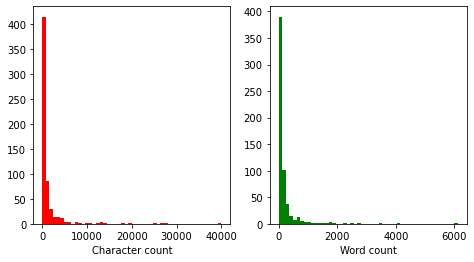

In [8]:
# Let's look at some histograms and see if there are any concerning outliers
char_counts = np.array([len(d) for d in clean_newsgroup_data.data])
word_counts = np.array([len(d.split()) for d in clean_newsgroup_data.data])
# can we keep track of how many lines are in each document as well?

# make a figure 3x as wide as it is tall
# this will allow us 3 subplots in one plot!
plt.figure(figsize=(12, 4))

# plot 1: character counts
plt.subplot(1, 3, 1) # this says this is the first of the plots in 1 row and 3 columns
plt.hist(x=char_counts, bins=50, color='red', label='Characters')
plt.xlabel("Character count")

# plot 2: word counts
plt.subplot(1, 3, 2) 
plt.hist(x=word_counts, bins=50, color='green', label='Words')
plt.xlabel("Word count")

# how would we make the third plot a blue plot of the number of lines in each?

**Exercise**: Right now there are two plots - but it might also be good to check if every document has a reasonable number of lines. How could we add a third plot (in blue, if you like) to do that?

Okay, there's nothing ridiculous, but we do see a sort of expected pattern of lots of shorter documents, and a few that are quite long. Just to make sure there's nothing weird going on in the larger documents, let's go ahead and print documents with more than 20,000 characters:

In [23]:
long_documents = [doc for doc in clean_newsgroup_data.data if len(doc) > 20000]

# looking at an example
print("Number of long documents:", len(long_documents))
print()
print(data_by_idx(0, data=long_documents, full=True))

Number of long documents: 4

COMMERCIAL SPACE NEWS/SPACE TECHNOLOGY INVESTOR NUMBER 22

   This is number twenty-two in an irregular series on commercial 
space activities.  The commentaries included are my thoughts on 
these developments.  

   Sigh... as usual, I've gotten behind in getting this column 
written.  I can only plead the exigency of the current dynamics in 
the space biz.  This column is put together at lunch hour and after 
the house quiets down at night, so data can quickly build up if 
there's a lot of other stuff going on.  I've complied a lot of 
information and happenings since the last column, so I'm going to 
have to work to keep this one down to a readable length.  Have fun! 

CONTENTS:
1- US COMMERCIAL SPACE SALES FLATTEN IN 1993
2- DELTA WINS TWO KEY LAUNCH CONTRACTS
3- COMMERCIAL REMOTE SENSING VENTURE GETS DOC "GO-AHEAD"
4- INVESTMENT FIRM CALLS GD'S SPACE BIZ "STILL A GOOD INVESTMENT" 
5- ARIANE PREDICTS DIP IN LAUNCH DEMAND
6- NTSB INVESTIGATES PEGASUS LAU

**Exercise** Check out a few documents in this list. Anything we notice about them that's unusual? Don't keep reading until you do this!

It looks like these documents include long, multi-chapter reports. The nice thing is these appear to be legitimate text (often, outliers I run into in digital corpora are signs that something got garbled). Unfortunately, they are quite long. In some tasks, it might make sense to split the text into smaller "pseudo-documents" that will be treated as separate by the algorithm. Sometimes, this will be done just by splitting the text in terms of number of lines or words (e.g. "break every 100 words"). This has a risk of splitting text in weird places, though, so I often will do one of two things depending on what the text can support:
1. If there are clear, nicely-formatted paragraphs, I'll use newline characters to split the text and then put some number of paragraphs in each pseudo-document. That number might be 1 for something like basic text classification, or something longer for a more narrative-focused analysis. (I use a lot of topic models, which tend to like 100-500 words.)
2. If there aren't good paragraph boundaries, I'll use something that detects sentences to make similar but not uniform length text passages. We'll look more at this in a bit.

If you look through this for a bit (spoiler for the above), you'll also notice there are some things that aren't quite cleaned up. For example, there are some extra headings that didn't get cleaned out in the second document. Let's go ahead and write some extra custom cleaning - since the formatting is quite specific, we should be able to remove these without too much inspection of documents to make sure we're not deleting something that isn't a header.

In [24]:
def clean_text(text):
    text = re.sub(r'Archive-name: [^\n]*\n', '', text)  # remove header lines
    text = re.sub(r'Last-modified: [^\n]*\n', '', text) # remove header lines
    # how would you replace digits with a '#' symbol?
    return text

In [26]:
print(clean_text(data_by_idx(1, full=True, data=long_documents)))


REFERENCES ON SPECIFIC AREAS

    PUBLISHERS OF SPACE/ASTRONOMY MATERIAL

    Astronomical Society of the Pacific
    1290 24th Avenue
    San Francisco, CA 94122

	More expensive but better organized slide sets.

    Cambridge University Press
    32 East 57th Street
    New York, NY 10022

    Crawford-Peters Aeronautica
    P.O. Box 152528
    San Diego, CA 92115
    (619) 287-3933

	An excellent source of all kinds of space publications. They publish
	a number of catalogs, including:
	    Aviation and Space, 1945-1962
	    Aviation and Space, 1962-1990
	    Space and Related Titles

    European Southern Observatory
    Information and Photographic Service
    Dr R.M. West
    Karl Scharzschild Strasse 2
    D-8046 Garching bei Munchen
    FRG

	Slide sets, posters, photographs, conference proceedings.

    Finley Holiday Film Corporation
    12607 East Philadelphia Street
    Whittier, California 90601
    (213)945-3325
    (800)FILMS-07

	Wide selection of Apollo, Shuttle, Vikin

Okay, that seemed to help. Let's look at features.

## Generating tokens

When we want to count lexical features in text, we usually are interested in splitting text into working units containing a word, phrase, punctuation mark, or another kind of countable occurrence. We call these elements *tokens*, and the process of splitting *tokenization*.

Tokens can share a *type*. For instance, I've written the word "we" in this three times prior to this point: twice with a capital W, once with a lowercase w. Depending on how we want to define our types, we could say that "we" and "We" are different types, with two tokens of type "We" and one of type "we". Quite often, we'll choose to *case fold*, or treat lowercase and uppercase words in English as the same. More often than not, that's implemented by just lower-casing all of our text.

A nice way to get a quick initial cut of some counts of different lexical features is using a `CountVectorizer`, a class from `scikit-learn` that takes a list of strings and (a) tokenizes them and (b) stores all of those counts in a matrix, or 2-D data structure of counts for each document and type. Rather than defining how it does this, let's start by taking a look by just feeding it the whole clean collection:

In [27]:
cv = CountVectorizer(stop_words='english')
# can we adjust this to clean the data?
count_data = cv.fit_transform([clean_text(t) for t in clean_newsgroup_data.data])

print("Count matrix dimensions (documents x features):", count_data.shape)
print(count_data)

Count matrix dimensions (documents x features): (593, 13273)
  (0, 7607)	2
  (0, 10605)	1
  (0, 8361)	1
  (0, 5588)	2
  (0, 10072)	1
  (0, 8747)	1
  (0, 3690)	1
  (0, 10528)	1
  (0, 3761)	1
  (0, 8162)	1
  (0, 8753)	2
  (0, 1857)	1
  (0, 8187)	1
  (0, 3016)	1
  (0, 8514)	1
  (0, 8076)	1
  (0, 7280)	1
  (0, 3960)	1
  (0, 9375)	1
  (0, 11375)	1
  (0, 8167)	3
  (0, 5945)	2
  (0, 5293)	2
  (0, 9338)	1
  (0, 7740)	1
  :	:
  (592, 2418)	1
  (592, 7363)	1
  (592, 3577)	1
  (592, 3387)	1
  (592, 3506)	2
  (592, 3026)	3
  (592, 2174)	1
  (592, 5292)	1
  (592, 8640)	1
  (592, 1586)	1
  (592, 2209)	1
  (592, 4952)	2
  (592, 2172)	1
  (592, 2834)	1
  (592, 2416)	1
  (592, 7357)	1
  (592, 11379)	1
  (592, 1769)	2
  (592, 618)	1
  (592, 13226)	1
  (592, 7462)	1
  (592, 1915)	1
  (592, 5594)	1
  (592, 1206)	1
  (592, 3704)	1


If you were expecting to see the 2D structure of a matrix (with 593 documents as rows and >13k word types as columns), this might be a bit confusing. When we count words in text, we usually expect most types in our vocabulary not to show up in most places, so if we made a full matrix of data, we would have a whole bunch of 0s and a much smaller proportion of 1s. To help cope with the storage inefficiency that would have, `scikit-learn` uses a *sparse* representation of the data: for each nonzero value in the matrix, it stores the row, column, and value. When we printed our matrix, we saw this format. 

Let's also look at the kinds of features we get out:

In [14]:
features = cv.get_feature_names()
# note: soon to be deprecated, will be replaced with cv.get_feature_names_out
print(', '.join(features))

00, 000, 0000, 00000, 000000, 000062david42, 00041032, 0004136, 0004246, 0004422, 00044513, 0004847546, 0005, 00090711, 0012, 0018, 0020, 0022, 0028, 0029, 0033, 0034, 006, 0065, 0098, 01, 01826, 018b, 02, 020359, 02115, 02138, 02139, 02178, 023b, 0245, 03, 030, 0300, 034, 034101, 04, 040, 04110, 041493003715, 045, 05, 050, 0500, 0545, 054589e, 058, 06, 060, 0605, 06111, 06179397, 06487, 067, 0674, 0695, 07, 070, 0739, 074, 08, 08080, 0820, 08540, 08544, 0856e16, 0865, 09, 0941, 0970, 0971, 0988, 0km, 0w, 10, 100, 1000, 10000, 1000r, 10019, 10020, 10022, 10023, 10036, 100k, 100km, 100nm, 100th, 101, 10158, 102, 10281, 1030, 104, 1044, 10460, 1049, 105, 105366, 1059, 105m, 106, 107, 1079, 1084, 109125, 109147, 10bps, 10cm, 10km, 10kw, 10m, 11, 110, 1100, 110m, 111, 111s, 112, 113, 115, 1150, 1151, 115m, 1163, 1179, 11888, 119, 1190, 119th, 12, 120, 1200, 1200mi, 1204, 1207, 121, 1212, 122, 1220, 1222, 122nd, 1234, 1238, 125, 12607, 12649, 12770, 128, 129, 1290, 1292, 12km, 12m, 13, 130,

**Exercise** Skim the features. What sorts of things are treated as distinct types? Do you think this is using case folding? Is there anything you think should be excluded?

Right now, this system is using a regular expression to split text into alphanumeric sequences and punctuation sequences. We can see that it's including a lot of apparently random number sequences. These features aren't usually helpful for text analysis because they're too rare to be part of a meaningful pattern - they probably identify a specific author, thread, or message uniquely, but they don't tell us much else. Usually there are lots of these if we just count everything, so we may want to remove some of these unique elements.

The other type of feature we might want to remove are words that aren't distinguishing because they're too common. We usually refer to these as `stopwords`. Stopwords refer to words that are ignored by a text processing system because they're not relevant to the task at hand. There are canonical lists circulated for particular languages - for instance, `Scikit-learn` has one built in for English:

In [15]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(ENGLISH_STOP_WORDS)

frozenset({'wherein', 'latter', 'part', 'about', 'perhaps', 'the', 'he', 'upon', 'no', 'becomes', 'cant', 'but', 'so', 'hasnt', 'ours', 'former', 'your', 'whom', 'one', 'de', 'somehow', 'me', 'never', 'twelve', 'seem', 'something', 'well', 'his', 'still', 'beforehand', 'cannot', 'under', 'herein', 'thence', 'call', 'side', 'somewhere', 'us', 'towards', 'very', 'while', 'front', 'besides', 'anyone', 'some', 'twenty', 'nevertheless', 'thereafter', 'every', 'always', 'everyone', 'ourselves', 'who', 'find', 'whatever', 'whole', 'yourselves', 'another', 'can', 'five', 'sixty', 'would', 'much', 'get', 'third', 'they', 'should', 'by', 'formerly', 'although', 'that', 'whoever', 'otherwise', 'nowhere', 'further', 'him', 'name', 'done', 'around', 'if', 'often', 'thereby', 'become', 'therein', 'in', 'however', 'during', 'hereby', 'nor', 'herself', 'see', 'back', 'mine', 'all', 'could', 'inc', 'less', 'made', 'most', 'hereafter', 'fifteen', 'nobody', 'everything', 'were', 'six', 'up', 'elsewhere',

You might notice this list doesn't have any punctuation marks inside "can't" and "couldn't". Some lists don't have contractions at all, some have punctuation, and some are split by certain tokenizers into units like "can" and "n't". No stoplist is actually universal - they're adapted for choices of domain and tokenization scheme. If we wanted to remove these, we could use the argument `stop_words='english'` in the constructor of the `CountVectorizer`. But in general, I am skeptical about trusting these lists on their own, especially because they can remove interesting words (for instance, I think "everywhere" is a pretty interesting word!)

Of course, we can alter our tokenization scheme. While we can give an alternate regular expression directly to the `CountVectorizer`, I like using NLTK's tokenization support, as they have nice interfaces for tokenization. NLTK Tokenizer objects, like the `RegexpTokenizer` below, have a `tokenize` method that takes in text and returns a list of tokens. The `CountVectorizer` is happy to take a tokenizer function in as an argument, so you can use [something fancier](https://www.nltk.org/api/nltk.tokenize.html) than a regular expression from NLTK if you want!

In [29]:
# this is a simpler tokenization option: one or more (+) letter characters (\w)
retok = RegexpTokenizer(r'[A-Za-z]+')

def tokenize_words(input_string):
    return retok.tokenize(input_string.lower())

One other cool thing our `CountVectorizer` supports is vocabulary curation. Rather than giving a stoplist, we can specify which word types we want to keep based on what proportion of documents they appear in. In this case, I'd like word types that show up in at least 5 documents but no more than 30% of all documents. I'll do this by setting `min_df=5` and `max_df=0.3`. Here, `df` is **document frequency**. If we give a positive integer for either of these, it'll use *absolute* document frequency, i.e. a count, as a threshold; if we give a float between 0 and 1, it will use that number as a proportion of the corpus, or *relative* document frequency threshold. Using this, we can prune our feature list dramatically, getting rid of both rare and common features.

In [28]:
clean_cv = CountVectorizer(
    tokenizer=tokenize_words,    # use this function to split text
    min_df=5,                    # minimum # of documents to show up in
    max_df=0.3)                  # maximum proportion of documents to show up in
# can we adjust this to clean the data?
clean_count_data = clean_cv.fit_transform([t for t in clean_newsgroup_data.data])

# we should have many fewer features
print("New count matrix dimensions (documents x features):", clean_count_data.shape)

New count matrix dimensions (documents x features): (593, 2380)


Let's see what features we now have:

In [17]:
clean_features = clean_cv.get_feature_names()

print("Stoplist:", ', '.join(clean_cv.stop_words_))

for test_word in ['the', 'is', 'was', 'could', 'isn', 'msu', 'milky way']:
    print(test_word, "in features:", test_word in clean_features)

Stoplist: household, kk, waterwood, contains, doees, determinations, waterloo, chimpanzee, admit, sron, trading, airport, walked, solicitation, nichols, tpa, cyclically, ubn, demonstarted, carrot, dcx, hazards, assess, mariatta, nearly, magnetism, glennc, puffs, spool, hurdles, ariadne, salisbury, maps, penalties, davies, capitalist, cylinders, butter, independent, flattering, vega, umbilical, blvd, lambeth, songs, barrel, marco, makeup, eaten, suns, mrose, brasil, sponsored, gummint, ips, sentence, liked, nationalist, ilmenite, inquiring, disadvantages, daniel, ulysses, whew, seasons, lindbergh, art, oneil, std, malfunction, ne, seconde, decades, dailey, profiting, supercar, reluctant, coverage, diagram, purposes, fruitless, instrumentation, benefits, replaced, keys, radios, photograph, plotter, speulate, fell, practise, ties, almanac, ventures, claim, advising, applicable, expressly, horizontially, mad, datum, overall, slips, orleans, dimensional, mostest, modular, bankst, indigenous

This looks like a lot more promising a list, as we have a lot of recognizable words!

**Exercise**: replace the tokenizer above with the function `nltk.tokenize.word_tokenize` (which you'll need to import). How dos that change the behavior?

In [18]:
tokenized_docs = [tokenize_words(clean_text(d)) for d in clean_newsgroup_data.data]

bigram_finder = BigramCollocationFinder.from_documents(tokenized_docs)
bigram_finder.apply_freq_filter(5)
for w1, w2 in bigram_finder.nbest(BigramAssocMeasures.pmi, 100):
    print(w1, w2)

wales larrison
hong kong
carl sagan
dani eder
dn volts
mcwilliams wk
topex poseidon
cl msu
kjenks gothamcity
tmp rcst
cape canaveral
chrisj emx
cd rom
mystery grows
zoo toronto
ingress egress
isu isunet
gao nsiad
los angeles
nssdca gsfc
willmann bell
baalke kelvin
pasadena calif
ken jenks
massachusetts avenue
emx cc
cc utexas
colorado springs
ring ingress
tommy mac
houston tx
ron baalke
increases tm
egalon larc
cs cmu
orthodox physicists
incoming geode
celestial bbs
map projections
ibm cl
tom mcwilliams
ics uci
crystal city
physicist dewey
loss timer
bulletin board
mailing lists
vision increases
aw st
mark prado
mcdonnell douglas
et al
external tank
mary shafer
extreme ultraviolet
fidonet org
york ny
south korea
advisory committee
cold war
tm ibm
gothamcity jsc
united states
south korean
tele operated
vice president
anti matter
safe mode
thu apr
mac tom
element sets
interactive computer
henry spencer
white dwarf
white sands
expiration date
interstellar travel
het symposium
po box
perfe

In [23]:
# do *all* the processing!
nlp = spacy.load("en_core_web_sm")
new_data = list(nlp.pipe(clean_newsgroup_data.data))

In [24]:
example_doc = new_data[27]
print(example_doc, '\n')
type(example_doc)

Archive-name: space/astronaut
Last-modified: $Date: 93/04/01 14:39:02 $

HOW TO BECOME AN ASTRONAUT

    First the short form, authored by Henry Spencer, then an official NASA
    announcement.

    Q. How do I become an astronaut?

    A. We will assume you mean a NASA astronaut, since it's probably
    impossible for a non-Russian to get into the cosmonaut corps (paying
    passengers are not professional cosmonauts), and the other nations have
    so few astronauts (and fly even fewer) that you're better off hoping to
    win a lottery. Becoming a shuttle pilot requires lots of fast-jet
    experience, which means a military flying career; forget that unless you
    want to do it anyway. So you want to become a shuttle "mission
    specialist".

    If you aren't a US citizen, become one; that is a must.  After that,
    the crucial thing to remember is that the demand for such jobs vastly
    exceeds the supply.  NASA's problem is not finding qualified people,
    but thinning the 

spacy.tokens.doc.Doc

In [25]:
example_tokens = [tok for tok in example_doc]
for tok in example_tokens[:100]:
    print(tok.idx, tok, '\tlemma:', tok.lemma_, '\talpha:', tok.is_alpha, '\tpunct:', tok.is_punct, '\tstopword:', tok.is_stop, '\tPOS tag:', tok.pos_)

0 Archive 	lemma: archive 	alpha: True 	punct: False 	stopword: False 	POS tag: NOUN
7 - 	lemma: - 	alpha: False 	punct: True 	stopword: False 	POS tag: PUNCT
8 name 	lemma: name 	alpha: True 	punct: False 	stopword: True 	POS tag: NOUN
12 : 	lemma: : 	alpha: False 	punct: True 	stopword: False 	POS tag: PUNCT
14 space 	lemma: space 	alpha: True 	punct: False 	stopword: False 	POS tag: NOUN
19 / 	lemma: / 	alpha: False 	punct: True 	stopword: False 	POS tag: SYM
20 astronaut 	lemma: astronaut 	alpha: True 	punct: False 	stopword: False 	POS tag: NOUN
29 
 	lemma: 
 	alpha: False 	punct: False 	stopword: False 	POS tag: SPACE
30 Last 	lemma: last 	alpha: True 	punct: False 	stopword: True 	POS tag: ADV
34 - 	lemma: - 	alpha: False 	punct: True 	stopword: False 	POS tag: PUNCT
35 modified 	lemma: modify 	alpha: True 	punct: False 	stopword: False 	POS tag: VERB
43 : 	lemma: : 	alpha: False 	punct: True 	stopword: False 	POS tag: PUNCT
45 $ 	lemma: $ 	alpha: False 	punct: False 	stopword:

In [33]:
# count the frequency of different types of token based on their lemma and POS tag (e.g. "you_PRON" for the pronoun "you")
pos_token_counts = Counter([tok.lemma_+'_'+tok.pos_ for tok in example_doc if tok.is_alpha])
print(pos_token_counts.most_common(20))

[('and_CCONJ', 80), ('be_AUX', 79), ('the_DET', 77), ('a_DET', 40), ('of_ADP', 37), ('in_ADP', 37), ('will_AUX', 29), ('for_ADP', 28), ('to_PART', 26), ('NASA_PROPN', 25), ('astronaut_NOUN', 22), ('to_ADP', 21), ('you_PRON', 19), ('an_DET', 15), ('or_CCONJ', 15), ('Astronaut_PROPN', 14), ('Space_PROPN', 13), ('pilot_NOUN', 12), ('mission_NOUN', 12), ('candidate_NOUN', 12)]


___
[Proceed to next lesson: Text Data Curation 3/3 ->](./textcuration-3.ipynb)

# Exercises (Optional)

`If possible, include practice exercises for users to do on their own. These may have clear solutions or be more open-ended.`

# References (Optional)
No citations required but include this if you have cited academic sources. Use whatever format you like, just be consistent. Markdown footnotes are not well-supported in notebooks.[$^{1}$](#1) I suggest using an anchor link with plain html as shown.[$^{2}$](#2)

1. <a id="1"></a> Here is an anchor link footnote.
2. <a id="2"></a> D'Ignazio, Catherine and Lauren F. Klein. [*Data Feminism*](https://mitpress.mit.edu/books/data-feminism). MIT Press, 2020.